## Example 1

https://pyabc.readthedocs.io/en/latest/examples/parameter_inference.html

In [1]:
import os
import tempfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyabc
from scipy.stats import uniform, randint
from epydemix.calibration import ABCSampler

In [2]:
def model(parameter):
    return {"data": parameter["mu"] + 0.5 * np.random.randn()}

def distance(simulation, data):
    return abs(simulation["data"] - data["data"])

In [3]:
## Pyabc calibration
prior = pyabc.Distribution(mu=pyabc.RV("uniform", 0, 5))
abc = pyabc.ABCSMC(model, prior, distance, population_size=1000)

db_path = os.path.join(tempfile.gettempdir(), "test.db")
observation = 2.5
abc.new("sqlite:///" + db_path, {"data": observation})

history = abc.run(minimum_epsilon=0.1, max_nr_populations=10)

ABC.Sampler INFO: Parallelize sampling on 8 processes.
ABC.History INFO: Start <ABCSMC id=18, start_time=2025-04-09 22:31:38>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.22250239e+00.
ABC INFO: Accepted: 1000 / 2061 = 4.8520e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 6.07262541e-01.
ABC INFO: Accepted: 1000 / 2254 = 4.4366e-01, ESS: 8.3165e+02.
ABC INFO: t: 2, eps: 2.95391436e-01.
ABC INFO: Accepted: 1000 / 3616 = 2.7655e-01, ESS: 8.1749e+02.
ABC INFO: t: 3, eps: 1.48672286e-01.
ABC INFO: Accepted: 1000 / 6184 = 1.6171e-01, ESS: 6.7259e+02.
ABC INFO: t: 4, eps: 7.78900119e-02.
ABC INFO: Accepted: 1000 / 11767 = 8.4983e-02, ESS: 6.8196e+02.
ABC INFO: Stop: Minimum epsilon.
ABC.History INFO: Done <ABCSMC id=18, duration=0:00:44.505955, end_time=2025-04-09 22:32:23>


In [4]:
## Epydemix calibration
prior = {"mu": uniform(0, 5)}
abc_epydemix = ABCSampler(model, prior, {}, observation, distance)

results = abc_epydemix.calibrate(strategy="smc", num_generations=10, minimum_epsilon=0.1, num_particles=1000)

Starting ABC-SMC with 1000 particles and 10 generations

Generation 1/10 (epsilon: inf)
	Accepted 1000/1000 (acceptance rate: 100.00%)
	Elapsed time: 00:00:00

Generation 2/10 (epsilon: 1.226381)
	Accepted 1000/1906 (acceptance rate: 52.47%)
	Elapsed time: 00:00:10

Generation 3/10 (epsilon: 0.625072)
	Accepted 1000/2819 (acceptance rate: 35.47%)
	Elapsed time: 00:00:10

Generation 4/10 (epsilon: 0.320196)
	Accepted 1000/4464 (acceptance rate: 22.40%)
	Elapsed time: 00:00:11

Generation 5/10 (epsilon: 0.156339)
	Accepted 1000/7950 (acceptance rate: 12.58%)
	Elapsed time: 00:00:11

Generation 6/10 (epsilon: 0.077150)
	Accepted 1000/15796 (acceptance rate: 6.33%)
	Elapsed time: 00:00:13
Minimum epsilon reached


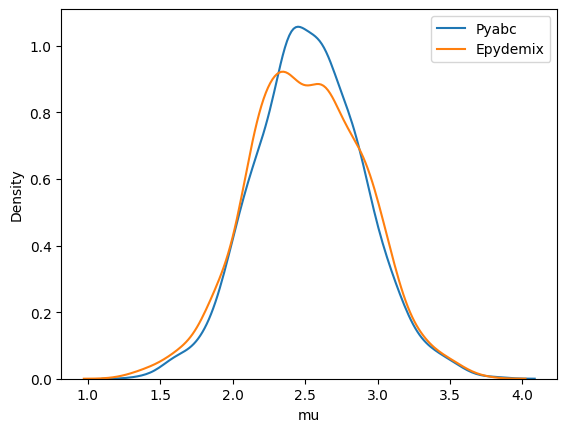

In [5]:
posterior_pyabc = history.get_distribution()[0]
posterior_epydemix = results.get_posterior_distribution()

sns.kdeplot(posterior_pyabc["mu"], label="Pyabc")
sns.kdeplot(posterior_epydemix["mu"], label="Epydemix")
plt.legend()
plt.show()

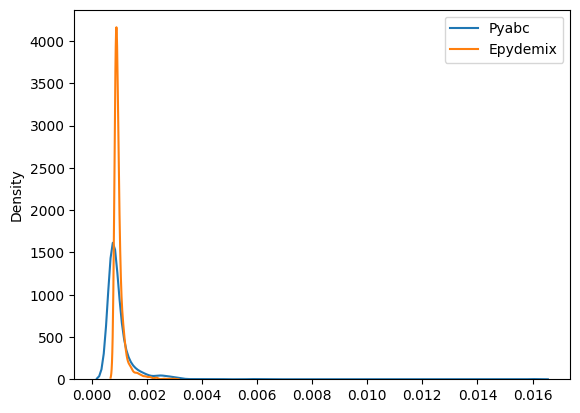

In [6]:
weights_pyabc = history.get_distribution()[1]
weights_epydemix = results.get_weights()    
sns.kdeplot(weights_pyabc, label="Pyabc")
sns.kdeplot(weights_epydemix, label="Epydemix")
plt.legend()
plt.show()

## Example 2

https://pyabc.readthedocs.io/en/latest/examples/discrete_parameters.html

In [7]:
n_data = 100

def model(p):
    return {
        'data': p['p_discrete']
        + np.random.choice([-2, 0, 2], p=[0.2, 0.5, 0.3])
        + p['p_continuous'] * np.random.normal(size=n_data)
    }


distance = lambda simulation, data: sum((simulation['data'] - data['data']) ** 2)
p_true = {'p_discrete': 2, 'p_continuous': 0.5}
obs = model(p_true)

In [8]:
# domain of possible discrete values
discrete_domain = np.arange(7)

# priors
prior = pyabc.Distribution(
    p_discrete=pyabc.RV('rv_discrete', values=(discrete_domain, [1 / 7] * 7)),
    p_continuous=pyabc.RV('uniform', 0, 2),
)

# transition kernels
transition = pyabc.AggregatedTransition(
    mapping={
        'p_discrete': pyabc.DiscreteJumpTransition(
            domain=discrete_domain, p_stay=0.7
        ),
        'p_continuous': pyabc.MultivariateNormalTransition(),
    }
)

abc = pyabc.ABCSMC(
    model, prior, distance, transitions=transition, population_size=1000
)
abc.new(pyabc.create_sqlite_db_id(), obs)
history = abc.run(max_nr_populations=5)

ABC.Sampler INFO: Parallelize sampling on 8 processes.
ABC.History INFO: Start <ABCSMC id=4, start_time=2025-04-09 22:34:20>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.20291010e+03.
ABC INFO: Accepted: 1000 / 1896 = 5.2743e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 4.47752874e+02.
ABC INFO: Accepted: 1000 / 2651 = 3.7722e-01, ESS: 9.2889e+02.
ABC INFO: t: 2, eps: 1.99411727e+02.
ABC INFO: Accepted: 1000 / 3783 = 2.6434e-01, ESS: 8.8801e+02.
ABC INFO: t: 3, eps: 1.26717783e+02.
ABC INFO: Accepted: 1000 / 5421 = 1.8447e-01, ESS: 8.4048e+02.
ABC INFO: t: 4, eps: 6.11245814e+01.
ABC INFO: Accepted: 1000 / 6187 = 1.6163e-01, ESS: 9.0579e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=4, duration=0:00:47.769853, end_time=2025-04-09 22:35:08>


In [9]:
prior = {"p_discrete": randint(0, 7), 
         "p_continuous": uniform(0, 2)}
abc_sampler = ABCSampler(model, prior, {}, obs['data'], distance)

results = abc_sampler.calibrate(strategy="smc", num_generations=6, num_particles=1000)

Starting ABC-SMC with 1000 particles and 6 generations

Generation 1/6 (epsilon: inf)
	Accepted 1000/1000 (acceptance rate: 100.00%)
	Elapsed time: 00:00:00

Generation 2/6 (epsilon: 1202.248714)
	Accepted 1000/1960 (acceptance rate: 51.02%)
	Elapsed time: 00:00:15

Generation 3/6 (epsilon: 445.619989)
	Accepted 1000/2713 (acceptance rate: 36.86%)
	Elapsed time: 00:00:15

Generation 4/6 (epsilon: 206.720968)
	Accepted 1000/4392 (acceptance rate: 22.77%)
	Elapsed time: 00:00:15

Generation 5/6 (epsilon: 130.536367)
	Accepted 1000/6223 (acceptance rate: 16.07%)
	Elapsed time: 00:00:18

Generation 6/6 (epsilon: 75.271329)
	Accepted 1000/6735 (acceptance rate: 14.85%)
	Elapsed time: 00:00:15


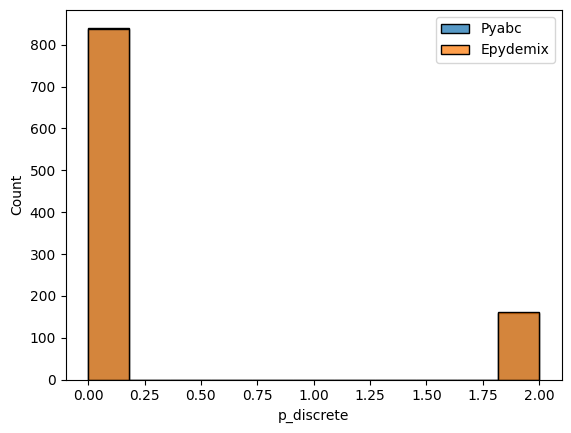

In [10]:
posterior_pyabc = history.get_distribution()[0]
posterior_epydemix = results.get_posterior_distribution()

sns.histplot(posterior_pyabc["p_discrete"], label="Pyabc")
sns.histplot(posterior_epydemix["p_discrete"], label="Epydemix")
plt.legend()
plt.show()

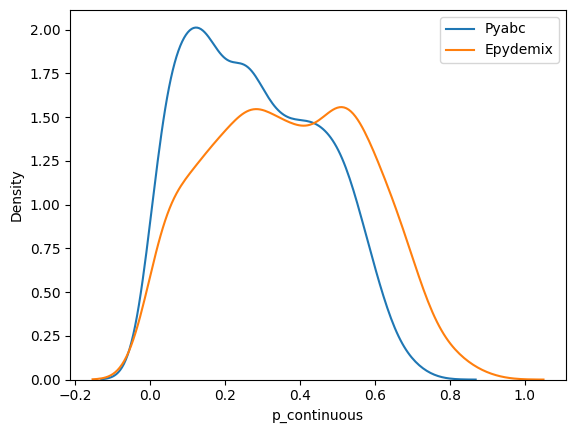

In [11]:
sns.kdeplot(posterior_pyabc["p_continuous"], label="Pyabc")
sns.kdeplot(posterior_epydemix["p_continuous"], label="Epydemix")
plt.legend()
plt.show()